<a href="https://colab.research.google.com/github/anubhav48/Catboost-vs-Lightboost-vs-XGBoost-vs-Snapboost/blob/master/XGB_LGBM_%26_CatBoost_on_Numeric_Data_with_HPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance of Gradient Boosting Algorithms on a Numeric Dataset

### This Notebook contains the comparative analysis of 3 Boosting Algorithms - 
### XGBoost, CatBoost and LightGBM trained and tested on a Numeric Dataset 



In [ ]:
#Installing the 3 boosting algorithms
!pip install xgboost --quiet
!pip install catboost --quiet
!pip install lightgbm --quiet
!pip install hyperopt --quiet

     |████████████████████████████████| 64.8MB 45kB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Importing Dependencies
import numpy as np
import pandas as pd
import sys
import os
from datetime import datetime
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from catboost import Pool,CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

## We use the Pokemon Numeric Dataset which can be found [here](https://www.kaggle.com/mlomuscio/pokemon).

Reading the Dataset

In [ ]:
input_path = r"/content/drive/My Drive/IBM/Pokemon_Numeric.csv"
data = pd.read_csv(input_path)

#### The goal is to predict whether a Pokemon is Legendary or not, given specific characteristics of each pokemon; such as Attack, Defense, Generation etc.

### Preliminary Analysis

In [ ]:
# Checking Basic information available from dataset
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    object
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(4)
memory usage: 75.9+ KB


In [ ]:
data[['HP', 'Attack', 'Defense']].head()
data[['HP', 'Attack', 'Defense']].describe()

,HP,Attack,Defense
count,800.000000,800.000000,800.000000
mean,69.258750,79.001250,73.842500
std,25.534669,32.457366,31.183501
min,1.000000,5.000000,5.000000
25%,50.000000,55.000000,50.000000
50%,65.000000,75.000000,70.000000
75%,80.000000,100.000000,90.000000
max,255.000000,190.000000,230.000000


Gaining some Insight into the data available

In [ ]:
# Isolated table of Attack and Defense features
atk_def = data[['Attack', 'Defense']]
atk_def.head()

,Attack,Defense
0,49,49
1,62,63
2,82,83
3,100,123
4,52,43


Polynomial Transformation

In [ ]:
# Figuring out the polynomial features and performing the transformation
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
res = pf.fit_transform(atk_def)
res

array([[   49.,    49.,  2401.,  2401.,  2401.],
       [   62.,    63.,  3844.,  3906.,  3969.],
       [   82.,    83.,  6724.,  6806.,  6889.],
       ...,
       [  110.,    60., 12100.,  6600.,  3600.],
       [  160.,    60., 25600.,  9600.,  3600.],
       [  110.,   120., 12100., 13200., 14400.]])

In [ ]:
# New dataframe with polynomial features included
pd.DataFrame(pf.powers_, columns=['Attack_degree', 'Defense_degree'])
intr_features = pd.DataFrame(res, columns=['Attack', 'Defense', 'Attack^2', 'Attack x Defense', 'Defense^2'])
intr_features.head(5)

,Attack,Defense,Attack^2,Attack x Defense,Defense^2
0,49.0,49.0,2401.0,2401.0,2401.0
1,62.0,63.0,3844.0,3906.0,3969.0
2,82.0,83.0,6724.0,6806.0,6889.0
3,100.0,123.0,10000.0,12300.0,15129.0
4,52.0,43.0,2704.0,2236.0,1849.0


### **Data Visualizations**

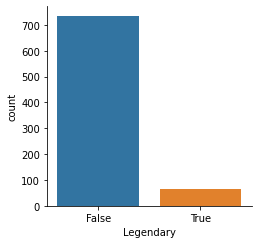

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
# Ground Truth Values of whether a pokemon is legendary or not
sns.factorplot('Legendary',data=data,kind='count',size = 3.5)

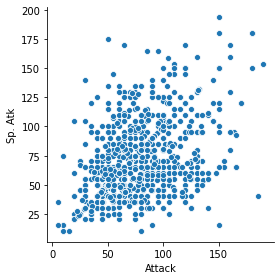

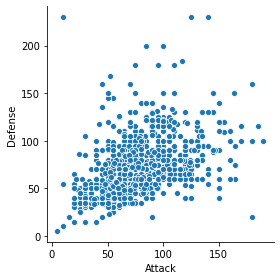

In [ ]:
sns.relplot(x = "Attack",y = "Sp. Atk",data = data,height = 4,aspect = 1)
sns.relplot(x = "Attack",y = "Defense",data = data,height = 4,aspect = 1)

As seen from the plots there is a strong correlation between the Features "Attack" and "Defense" w.r.t "Legendary" 

We Also retain the other numerical feature "Sp. Atk" as it also shows considerable correlation with "Attack"

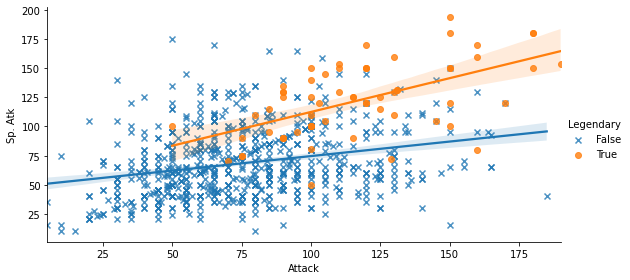

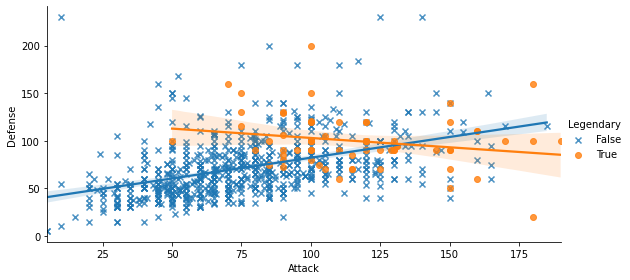

In [ ]:
sns.lmplot(x = "Attack",y = "Sp. Atk",hue = "Legendary", markers = ['x','o'],data = data,height = 4,aspect = 2)
sns.lmplot(x = "Attack",y = "Defense",hue = "Legendary", markers = ['x','o'],data = data,height = 4,aspect = 2)

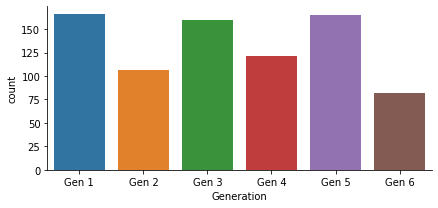

In [ ]:
sns.factorplot('Generation',data=data,kind='count',height = 3,aspect = 2)
# Generation Count

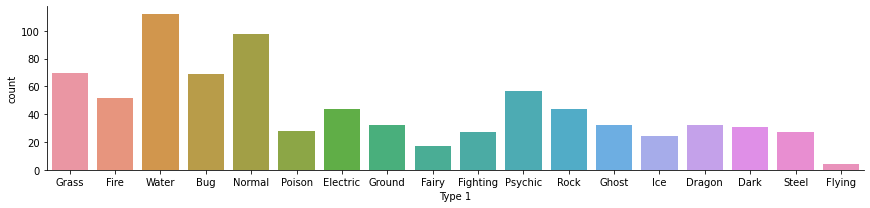

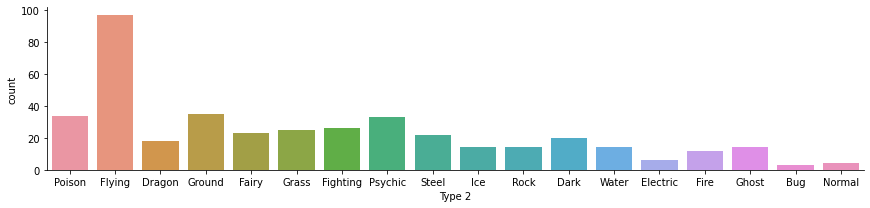

In [ ]:
# Analyzing the columns of Type 1 and Type 2
sns.factorplot('Type 1',data=data,kind='count',height = 3,aspect=4)
sns.factorplot('Type 2',data=data,kind='count',height = 3,aspect = 4)

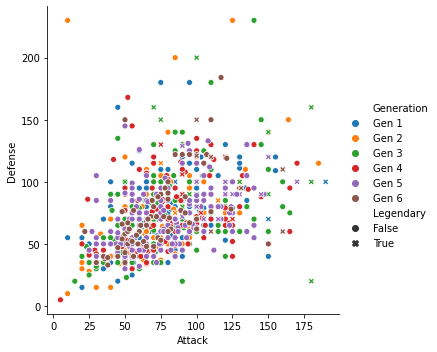

In [ ]:
"""
The correlation scatter plot of attack and defense w.r.t Generation categorized on whether
the pokemon is legendary or not 
"""
sns.relplot(x="Attack", y="Defense", hue="Generation", style="Legendary", data=data)

Since All the generations are approximately distributed around the mean of "Attack" and "Defense", we include them in our Predictions too 

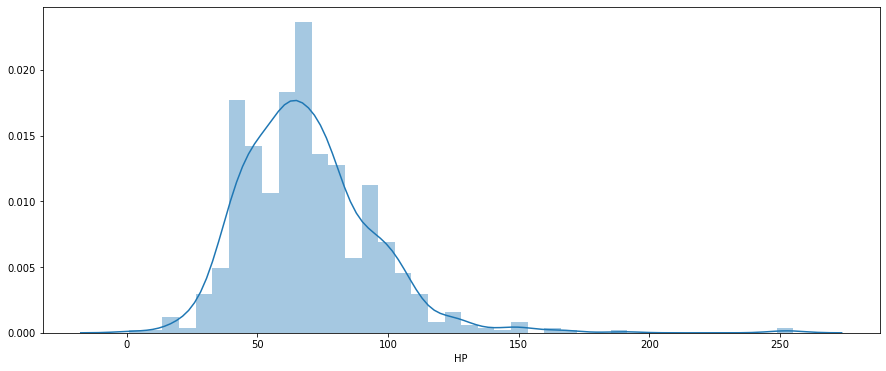

In [ ]:
# Visualizing the mean of HP
plt.figure(figsize = (15,6))
sns.distplot(data['HP'])

The following plot depicts the Generation by Generation Distribution of HP and also describes which of them are Legendary

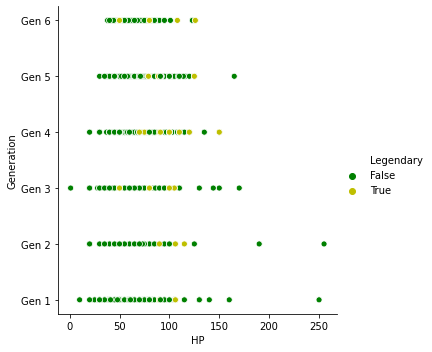

In [ ]:
g = sns.relplot(x="HP", y="Generation", hue="Legendary",
                palette=["g", "y"], sizes=(10, 100), data=data)

From the above Plot it is clear that the outliers in the data are minimal

Removing NaN's

In [ ]:
print(data.isnull().sum())
# There are 386 Null values within the data, and are only in column "Type 2"

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64


In [ ]:
# Populating The Null values with the statistical mode 

data['Type 2'].loc[(data['Type 2'].isnull())] = data['Type 2'].mode().max()
print(data['Type 2'].head(12))


0     Poison
1     Poison
2     Poison
3     Poison
4     Flying
5     Flying
6     Flying
7     Dragon
8     Flying
9     Flying
10    Flying
11    Flying
Name: Type 2, dtype: object


We see from the following plot, that Generation 2 and Generation 5 have the highest Probabilities of the Pokemon being Legendary

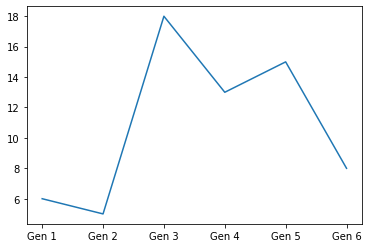

In [ ]:
df = data[data["Legendary"] == True].groupby(data["Generation"]).sum()
plt.plot(df['Legendary'])
plt.show()

Encoding the Columns containing Categorical Features (Type 1,Type 2, Generation) to Numeric using the Label Encoder Transformation

In [ ]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
data['Type 1'] = LE.fit_transform(data['Type 1'])
data['Type 2'] = LE.fit_transform(data['Type 2'])
data['Generation'] = LE.fit_transform(data['Generation'])
data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,9,13,318,45,49,49,65,65,45,0,False
1,2,Ivysaur,9,13,405,60,62,63,80,80,60,0,False
2,3,Venusaur,9,13,525,80,82,83,100,100,80,0,False
3,3,VenusaurMega Venusaur,9,13,625,80,100,123,122,120,80,0,False
4,4,Charmander,6,7,309,39,52,43,60,50,65,0,False


# Training and Testing

In [ ]:
train,test = train_test_split(data,test_size = 0.3,shuffle = True)
train_x,train_y = train[['Type 1','Type 2','Total','HP','Attack','Defense','Sp. Atk', 'Sp. Def','Speed','Generation']],train["Legendary"]
test_x,test_y = test[['Type 1','Type 2','Total','HP','Attack','Defense','Sp. Atk', 'Sp. Def','Speed','Generation']],test["Legendary"]

### 1. LightGBM Algorithm on the Dataset




#### HyperParameter Optimization with Hyperopt

In [ ]:
lgb_hps = { 'num_leaves': hp.choice('num_leaves',np.arange(100, 200, 10, dtype=int)),
            'max_depth': hp.choice('max_depth',np.arange(5, 16, 1, dtype=int)),
            'n_estimators': hp.quniform('n_estimators', 10, 700, 1),
            'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
            'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
            'learning_rate': hp.loguniform('learning_rate', -5.0, -2.3),
            'lambda_l1': hp.uniform('lambda_l1', 0, 10),
            'lambda_l2': hp.uniform('lambda_l2', 0, 10)
          }

num_leaves_list = [100,110,120,130,140,150,160,170,180,190,200]

In [ ]:
accuracy_list_lgbm = []
def HPO_lgbm(lgb_hps):
    num_round = 50
    train_data=lgb.Dataset(train_x,label=train_y)
    lgbm=lgb.train(lgb_hps,train_data,num_round)
    ypred2=lgbm.predict(test_x)
    accuracy_lgbm = roc_auc_score(test_y,ypred2).mean()
    accuracy_list_lgbm.append(accuracy_lgbm)
    return {'loss': -accuracy_lgbm, 'status': STATUS_OK }

In [ ]:
trials = Trials()
best_lgbm = fmin(fn= HPO_lgbm,
            space= lgb_hps,
            algo= tpe.suggest,
            max_evals = 80,
            trials = trials
            )
max_acc_lgbm = max(accuracy_list_lgbm)
print("Best Hyperparameters for LGBM are: \n")
best_lgbm

100%|██████████| 80/80 [00:20<00:00,  3.84it/s, best loss: -0.9885687068349607]
Best Hyperparameters for LGBM are: 



{'bagging_fraction': 0.9975640478075846,
 'feature_fraction': 0.9712014001069452,
 'lambda_l1': 0.04892687552846475,
 'lambda_l2': 1.7286617924449281,
 'learning_rate': 0.012062669954831627,
 'max_depth': 4,
 'n_estimators': 549.0,
 'num_leaves': 3}

##### Hyper-Parameters Vs. Accuracy Graphs

Best num_leaves   =   3
Best max_depth   =   4
Best n_estimators   =   549.0
Best feature_fraction   =   0.9712014001069452
Best bagging_fraction   =   0.9975640478075846
Best learning_rate   =   0.012062669954831627
Best lambda_l1   =   0.04892687552846475
Best lambda_l2   =   1.7286617924449281


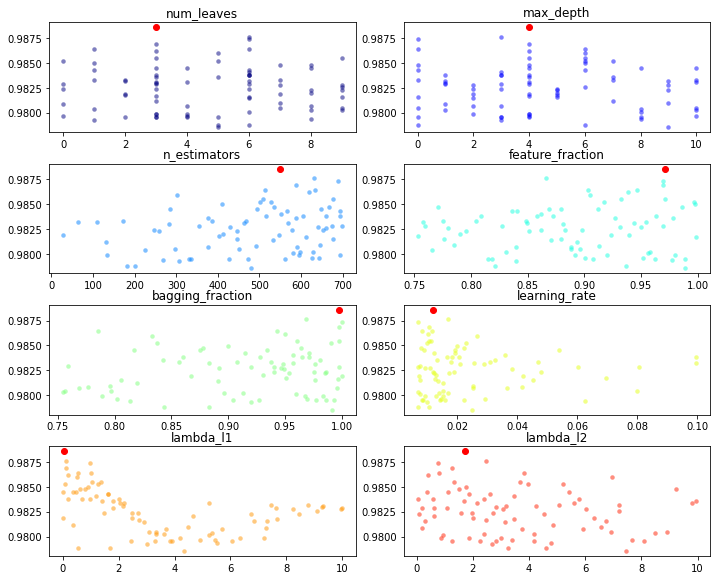

In [ ]:
parameters = ['num_leaves','max_depth','n_estimators','feature_fraction','bagging_fraction','learning_rate','lambda_l1','lambda_l2']
f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print("Best " + str(val) + "   =   " + str(best_lgbm[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_lgbm[val],max_acc_lgbm,color = "red")
    axes[i//2,i%2].set_title(val)

#### Actual Training on LGBM with chosen HPs

In [ ]:
params = { 
            'num_leaves': num_leaves_list[best_lgbm['num_leaves']],
            'max_depth': best_lgbm['max_depth'],
            'n_estimators': best_lgbm['n_estimators'],
            'feature_fraction':best_lgbm['feature_fraction'],
            'bagging_fraction':best_lgbm['bagging_fraction'],
            'learning_rate':best_lgbm['learning_rate'],
            'lambda_l1': best_lgbm['lambda_l1'],
            'lambda_l2':best_lgbm['lambda_l2']
          }
train_data=lgb.Dataset(train_x,label=train_y)

num_round=100
t1=datetime.now()
lgbm=lgb.train(params,train_data,num_round)
t2=datetime.now()
execution_time_lgbm = t2-t1
t3 = datetime.now()
ypred2=lgbm.predict(test_x)
t4 = datetime.now()

for i in range(0,len(ypred2)): 
    if ypred2[i] >=0.5:
        ypred2[i] = 1
    else:
        ypred2[i] = 0
accuracy_lgbm = round(accuracy_score(ypred2,test_y),5)
print("Accuracy score = ",accuracy_lgbm*100,"%")
print("Execution time = ",execution_time_lgbm)
print("Prediction time = ",t4-t3)
lgbm_train_time = t2-t1

Accuracy score =  96.25 %
Execution time =  0:00:00.313287
Prediction time =  0:00:00.006300


### 2. CatBoost Algorithm on the Dataset

#### HyperParameter Optimization with Hyperopt

In [ ]:
cb_hps = {  
            'learning_rate':      hp.loguniform('learning_rate', -5.0, -2.3),
            'depth':              hp.choice('depth',np.arange(5,16,1,dtype = int)),
            'l2_leaf_reg':       hp.quniform('l2_leaf_reg',2, 16, 1),
            'random_seed':       hp.choice('random_seed',np.arange(5, 10, 1,dtype=int)),
            'colsample_bylevel': hp.quniform('colsample_bylevel',0.3, 0.8, 0.1),
            'n_estimators':      hp.choice('n_estimators',np.arange(100,160,10,dtype = int))
        }

depth_list = [i for i in range(5,16,1)]
est_list = [i for i in range(100,160,10)]

In [ ]:
accuracy_list_cb = []
cat_features = np.where(train_x.dtypes!=float)[0]
def HPO_cb(cb_hps):
    num_round = 50
    model = CatBoostClassifier(**cb_hps,silent = True)
    model.fit(train_x,train_y,cat_features = cat_features)
    pred = model.predict_proba(test_x)[:,1]
    accuracy_cb = roc_auc_score(test_y,pred).mean()
    accuracy_list_cb.append(accuracy_cb)
    return {'loss': -accuracy_cb, 'status': STATUS_OK }

In [ ]:
trials = Trials()
best_cb = fmin(fn= HPO_cb,
            space= cb_hps,
            algo= tpe.suggest,
            max_evals = 10,
            trials = trials
            )
max_acc_cb = max(accuracy_list_cb)
print("Best Hyperparameters for CatBoost are: \n")
best_cb

100%|██████████| 10/10 [00:02<00:00,  3.38it/s, best loss: -0.9909502262443438]
Best Hyperparameters for CatBoost are: 



{'colsample_bylevel': 0.6000000000000001,
 'depth': 1,
 'l2_leaf_reg': 7.0,
 'learning_rate': 0.04557643270978085,
 'n_estimators': 5,
 'random_seed': 4}

##### Hyper-Parameters Vs. Accuracy Graphs

Best n_estimators   =   150
Best random_seed   =   9
Best learning_rate   =   0.04557643270978085
Best depth   =   6
Best l2_leaf_reg   =   7.0
Best colsample_bylevel   =   0.6000000000000001


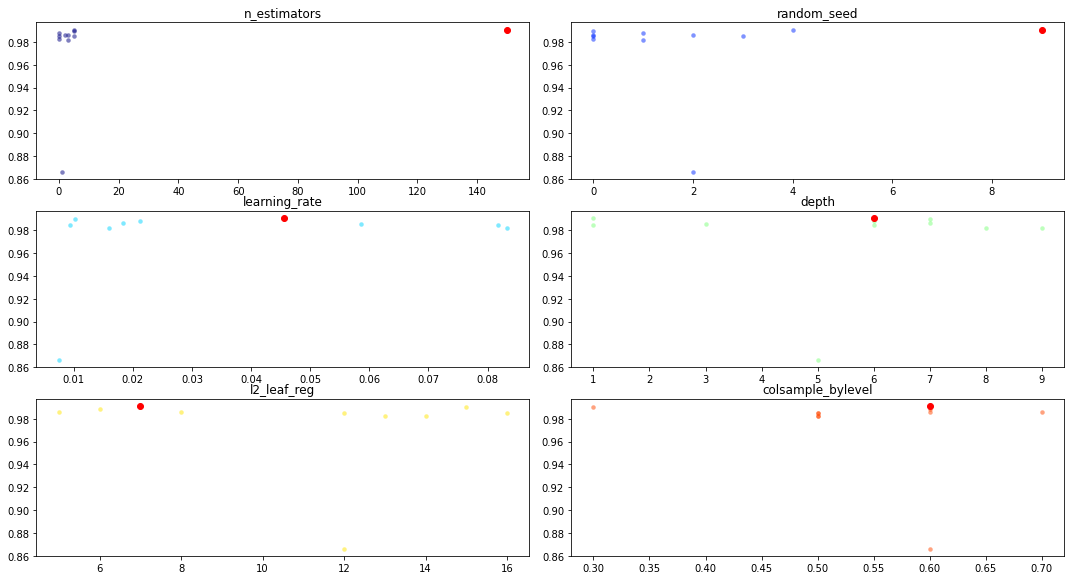

In [ ]:
parameters = ['n_estimators','random_seed','learning_rate','depth','l2_leaf_reg','colsample_bylevel']
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    if val == 'depth':
      best_cb[val] = depth_list[best_cb[val]]
    elif val == 'n_estimators':
      best_cb[val] = est_list[best_cb['n_estimators']]
    elif val == 'random_seed':
      best_cb[val]+=5
    print("Best " + str(val) + "   =   " + str(best_cb[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_cb[val],max_acc_cb,color = "red")
    axes[i//2,i%2].set_title(val)

#### Actual Training on CatBoost with chosen HPs

In [ ]:
cat_features = np.where(train_x.dtypes!=float)[0]
model = CatBoostClassifier(      
                                  n_estimators = best_cb['n_estimators'],
                                  colsample_bylevel = best_cb['colsample_bylevel'],
                                  learning_rate = best_cb['learning_rate'],
                                  l2_leaf_reg = best_cb['l2_leaf_reg'], 
                                  random_seed = best_cb['random_seed'],
                                  depth = best_cb['depth'],
                                  silent = True
                           )
t1=datetime.now()
model.fit(train_x,train_y,cat_features = cat_features)
t2=datetime.now()
execution_time_cat_boost = t2-t1
t3 = datetime.now()
pred = model.predict_proba(test_x)[:,1]
t4 = datetime.now()
accuracy_cat_boost = round(roc_auc_score(test_y,pred),5)
print("Accuracy score = ",accuracy_cat_boost*100,"%")
print("Execution time = ",execution_time_cat_boost)
print("Prediction time = ",t4-t3)
cat_boost_train_time = t2-t1

Accuracy score =  99.095 %
Execution time =  0:00:00.221655
Prediction time =  0:00:00.001904


### 3. XGBoost Algorithm on the Dataset

#### HyperParameter Optimization with Hyperopt

In [ ]:
xgb_hps = {  
            'learning_rate':     hp.loguniform('learning_rate', -5.0, -2.3),
            'max_depth':         hp.choice('max_depth',np.arange(5,16,1,dtype = int)),
            'lambda':            hp.quniform('lambda',2, 16, 1),
            'subsample':        hp.quniform('subsample',0.1,1.0,0.1),
            'colsample_bytree': hp.quniform('colsample_bytree',0.3, 0.8, 0.1),
            'min_split_loss' : hp.quniform('min_split_loss',0.1,2.0,0.1)
        }

depth_list = [i for i in range(5,16,1)]

In [ ]:
accuracy_list_xgb = []
def HPO_xgb(xgb_hps):
    model = model = XGBClassifier(**xgb_hps)
    model.fit(train_x,train_y)
    y_pred = model.predict(test_x)
    accuracy_xgb = accuracy_score(y_pred,test_y).mean()
    accuracy_list_xgb.append(accuracy_xgb)
    return {'loss': -accuracy_xgb, 'status': STATUS_OK }

In [ ]:
trials = Trials()
best_xgb = fmin(fn= HPO_xgb,
            space= xgb_hps,
            algo= tpe.suggest,
            max_evals = 80,
            trials = trials
            )
max_acc_xgb = max(accuracy_list_xgb)
print("Best Hyperparameters for XGBoost are: \n")
best_xgb

100%|██████████| 80/80 [00:06<00:00, 12.57it/s, best loss: -0.9791666666666666]
Best Hyperparameters for XGBoost are: 



{'colsample_bytree': 0.8,
 'lambda': 8.0,
 'learning_rate': 0.07072672246948117,
 'max_depth': 10,
 'min_split_loss': 0.5,
 'subsample': 1.0}

##### Hyper-Parameters Vs. Accuracy Graphs

Best max_depth   =   15
Best subsample   =   1.0
Best learning_rate   =   0.07072672246948117
Best min_split_loss   =   0.5
Best lambda   =   8.0
Best colsample_bytree   =   0.8


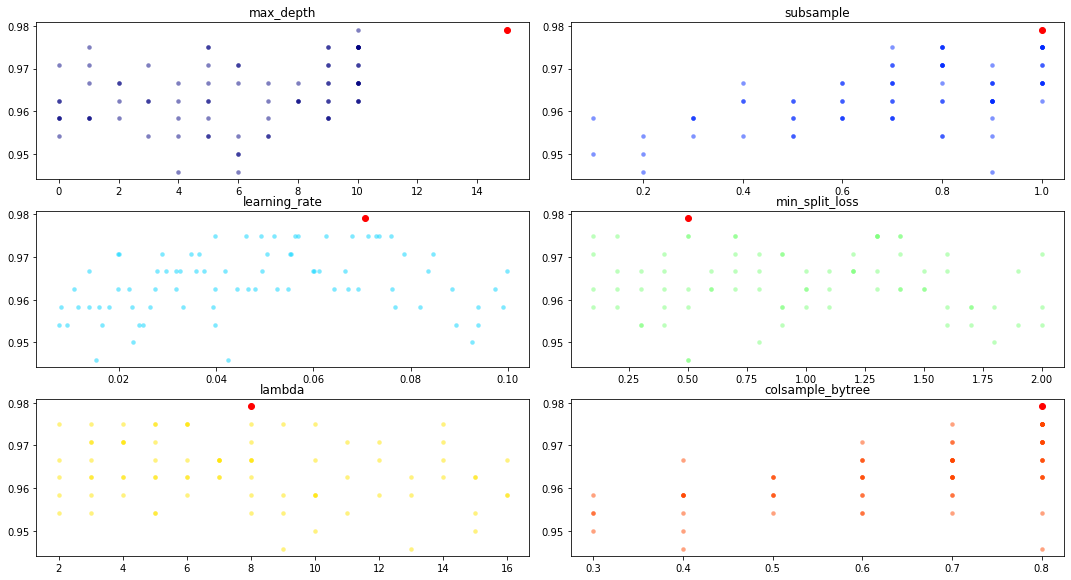

In [ ]:
parameters = ['max_depth','subsample','learning_rate','min_split_loss','lambda','colsample_bytree']
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    if val == 'max_depth':
      best_xgb[val] = depth_list[best_xgb[val]]
    print("Best " + str(val) + "   =   " + str(best_xgb[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_xgb[val],max_acc_xgb,color = "red")
    axes[i//2,i%2].set_title(val)

#### Actual Training on XGBoost with chosen HPs

In [ ]:
model = XGBClassifier(**best_xgb)
t1=datetime.now()
model.fit(train_x,train_y)
t2=datetime.now()
execution_time_xgb = t2-t1
t3 = datetime.now()
y_pred = model.predict(test_x)
t4 = datetime.now()
predictions = [round(value) for value in y_pred]
accuracy_xgb = round(accuracy_score(y_pred,test_y),5)
print("Accuracy score = ",accuracy_xgb*100,"%")
print("Execution time = ",execution_time_xgb)
print("Prediction time = ",t4-t3)
xgb_train_time = t2-t1

Accuracy score =  97.917 %
Execution time =  0:00:00.060218
Prediction time =  0:00:00.001422


# Results and Plots

### 1. Accuracy Plot

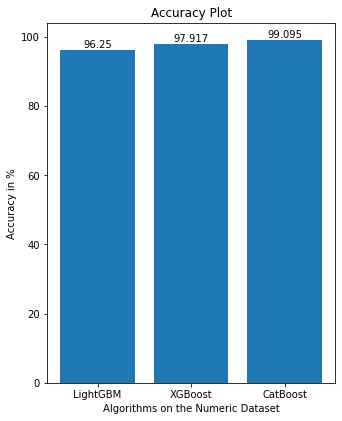

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (4,5))
ax = fig.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','CatBoost']
accuracy = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_cat_boost*100]
g = ax.bar(algorithms,accuracy)
plt.title("Accuracy Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Accuracy in %")
bar_label = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_cat_boost*100]
def autolabel(rects):
    for idx,rect in enumerate(g):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(g)
plt.show()

### 2. Training Time  Plot

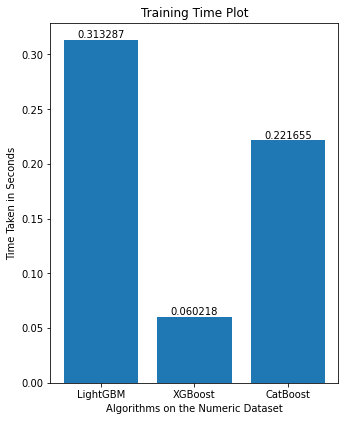

In [ ]:
lg = float(str(lgbm_train_time)[5:])
cb = float(str(cat_boost_train_time)[5:])
xgb = float(str(xgb_train_time)[5:])
fig1 = plt.figure(figsize = (4,5))
ay = fig1.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','CatBoost']
training_time = [lg,xgb,cb]
g1 = ay.bar(algorithms,training_time)
plt.title("Training Time Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Time Taken in Seconds")
bar_label = training_time
def autolabel1(rects):
    for idx,rect in enumerate(g1):
        height = rect.get_height()
        ay.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel1(g1)
plt.show()